In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
import time

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

In [4]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [5]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [6]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['ils peuvent chanter', 'they re able to sing']


In [7]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [8]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [9]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [10]:
from sklearn.model_selection import train_test_split

def get_data(batch_size = 32 , test_size=0.2):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
    first_pairs, test_pairs = train_test_split(pairs, test_size=test_size, random_state=42)
    train_pairs, valid_pairs = train_test_split(first_pairs, test_size=test_size, random_state=42)

    def prepare_dataset(pairs):
        n = len(pairs)
        input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
        target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

        for idx, (inp, tgt) in enumerate(pairs):
            inp_ids = indexesFromSentence(input_lang, inp)
            tgt_ids = indexesFromSentence(output_lang, tgt)
            inp_ids.append(EOS_token)
            tgt_ids.append(EOS_token)
            input_ids[idx, :len(inp_ids)] = inp_ids
            target_ids[idx, :len(tgt_ids)] = tgt_ids

        return TensorDataset(torch.LongTensor(input_ids).to(device),
                             torch.LongTensor(target_ids).to(device))

    train_data = prepare_dataset(train_pairs)
    test_data = prepare_dataset(test_pairs)
    valid_data = prepare_dataset(valid_pairs)

    # Creation of DataLoaders
    train_sampler = RandomSampler(train_data)
    valid_sampler = RandomSampler(valid_data)
    test_sampler = SequentialSampler(test_data)
    
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_size)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
    
    return input_lang, output_lang, pairs, train_dataloader, valid_dataloader, test_dataloader

In [45]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [46]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [47]:
def evaluate_test(dataloader, encoder, decoder, criterion):
    with torch.no_grad():
        total_loss = 0
        for data in dataloader:
            input_tensor, target_tensor = data
            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
            loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
            total_loss += loss.item()
        return total_loss / len(dataloader)

In [48]:
def train(train_dataloader, valid_dataloader, test_dataloader, encoder, decoder, n_epochs, learning_rate=0.001, print_every=100):
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    train_losses = []
    valid_losses = []
    test_losses = []

    start = time.time()

    for epoch in range(1, n_epochs + 1):
        encoder.train()
        decoder.train()
        train_loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        train_losses.append(train_loss)

        encoder.eval()
        decoder.eval()
        valid_loss = evaluate_test(valid_dataloader, encoder, decoder, criterion)
        valid_losses.append(valid_loss)
        
        test_loss = evaluate_test(test_dataloader, encoder, decoder, criterion)
        test_losses.append(test_loss)

        print(f'epoch {epoch} ===============  train loss : {train_loss},valid loss:{valid_loss}, test loss : {test_loss}')

        if epoch % print_every == 0:
            print(f'{timeSince(start, epoch / n_epochs)} ({epoch} {epoch / n_epochs * 100:.0f}%) Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    return train_losses,valid_losses, test_losses

# Exemple de création des dataloaders et modèles
# encoder = EncoderRNN(input_size, hidden_size)
# decoder = DecoderRNN(hidden_size, output_size)
# train_losses, test_losses = train(train_dataloader, test_dataloader, encoder, decoder, n_epochs)


In [49]:
def showPlot(train_losses,valid_losses,test_losses):
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training, Validation and Testing Loss per Epoch')
    plt.legend()
    plt.show()

In [50]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [51]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [52]:
input_lang, output_lang, pairs, train_dataloader, valid_dataloader, test_dataloader = get_data()

Reading lines...
Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991


In [53]:
hidden_size = 128
batch_size = 32


encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train_losses,valid_losses, test_losses = train(train_dataloader, valid_dataloader, test_dataloader, encoder, decoder, 80, learning_rate=0.001, print_every=100)

epoch 1 ===============  train loss : 2.901304437604013,valid loss:2.2718212625076033, test loss : 2.181179036696752
epoch 2 ===============  train loss : 2.008628620330944,valid loss:1.9638476063465249, test loss : 1.8753425925970078
epoch 3 ===============  train loss : 1.7393281470219641,valid loss:1.794225324844492, test loss : 1.7102476523982153
epoch 4 ===============  train loss : 1.5592312719103552,valid loss:1.6835969994808067, test loss : 1.5972787969642215
epoch 5 ===============  train loss : 1.4165882809193373,valid loss:1.5941968868518699, test loss : 1.5122597449355655
epoch 6 ===============  train loss : 1.3002868656508266,valid loss:1.5399642360621486, test loss : 1.4491548720333312
epoch 7 ===============  train loss : 1.198003835553165,valid loss:1.48797961350145, test loss : 1.397549988494979
epoch 8 ===============  train loss : 1.1102495878023872,valid loss:1.4558578482989608, test loss : 1.3646040078666475
epoch 9 ===============  train loss : 1.0287096159426927

epoch 70 ===============  train loss : 0.04560155906271206,valid loss:1.7027192033570389, test loss : 1.5351270702150133
epoch 71 ===============  train loss : 0.044121765999294266,valid loss:1.7007265892522088, test loss : 1.539716853035821
epoch 72 ===============  train loss : 0.04189212224954601,valid loss:1.7167764922668194, test loss : 1.5519557653201952
epoch 73 ===============  train loss : 0.04241542698709725,valid loss:1.7430970093299603, test loss : 1.5574711950288878
epoch 74 ===============  train loss : 0.04067797423645399,valid loss:1.7241927015370335, test loss : 1.5604073132077854
epoch 75 ===============  train loss : 0.040269825721411724,valid loss:1.7541513936272983, test loss : 1.5677171953850322
epoch 76 ===============  train loss : 0.03982160867936096,valid loss:1.7452941084730214, test loss : 1.5873319134116173
epoch 77 ===============  train loss : 0.03846564373269872,valid loss:1.776980996131897, test loss : 1.5799506993757353
epoch 78 ===============  train 

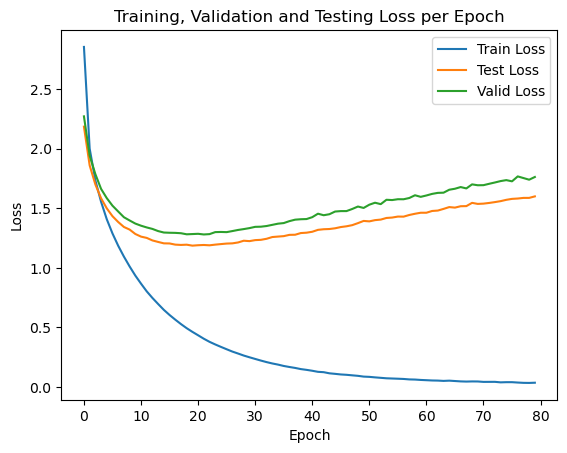

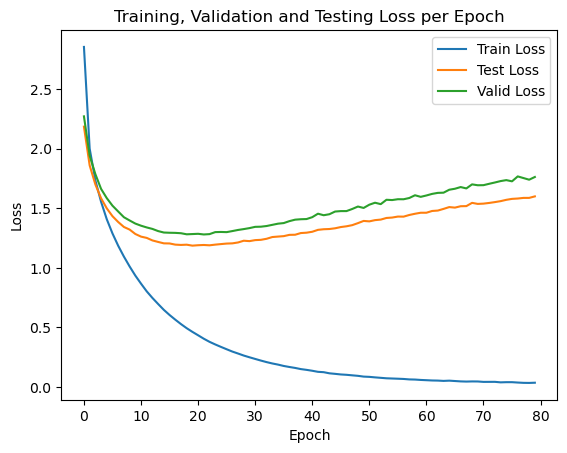

In [37]:
%matplotlib inline
showPlot(train_losses,valid_losses,test_losses)

In [38]:
encoder.eval()

EncoderRNN(
  (embedding): Embedding(4601, 128)
  (gru): GRU(128, 128, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [39]:
decoder.eval()

DecoderRNN(
  (embedding): Embedding(2991, 128)
  (gru): GRU(128, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=2991, bias=True)
)

In [97]:
evaluateRandomly(encoder, decoder)

> ils distribuent des echantillons gratuits
= they re giving away samples free
< they re leaving us tomorrow <EOS>

> je ne suis pas content
= i am not happy
< i m not sure if it <EOS>

> il est genereux avec son argent
= he is generous with his money
< he is generous with his money <EOS>

> je vais etre votre professeur
= i m going to be your teacher
< i m going to need your help <EOS>

> il est en train de faire des cookies
= he is making cookies
< he is thinking of painting working famous <EOS>

> elles sont toutes terrifiees
= they re all terrified
< they are all afraid of death <EOS>

> elle est certaine de reussir les examens
= she is certain to pass the exam
< she is certain to pass the subject <EOS>

> j ecoute
= i m listening
< i m listening to bjork s latest song <EOS>

> vous etes aveugle par l amour
= you are blinded by love
< you are trusted by every one of us problem <EOS>

> je m en occupe
= i m taking care of it
< i m breaking the part of the class <EOS>



In [24]:
def tran(sentence,encoder,decoder):
    sentence = re.sub(r"([.!?])", r" \1", sentence)
    sentence = re.sub(r"[^a-zA-Z!?]+", r" ", sentence)
    output_words, _ = evaluate(encoder, decoder, sentence, input_lang, output_lang)
    output_sentence = ' '.join(output_words)
    print(output_sentence)

In [55]:
tran('il est pauvre', encoder,decoder)

he is poor but she s girl <EOS>


In [78]:
tran('je ne suis pas en forme et je n en peux plus de toutes ces disputes',encoder,decoder)

i m probably in no more a nervous wreck <EOS>


### With BLUE evaluation

In [20]:
def sentenceFromTensor(lang, tensor):
    words = [lang.index2word[idx.item()] for idx in tensor if idx.item() not in (SOS_token, EOS_token)]
    return ' '.join(words)

def evaluate_bleu(dataloader, encoder, decoder, input_lang, output_lang):
    references = []
    candidates = []
    with torch.no_grad():
        for data in dataloader:
            input_tensor, target_tensor = data
            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden)

            for i in range(input_tensor.size(0)):
                candidate = sentenceFromTensor(output_lang, torch.argmax(decoder_outputs[i], dim=1))
                reference = sentenceFromTensor(output_lang, target_tensor[i])
                candidates.append(candidate.split())
                references.append([reference.split()])

    return corpus_bleu(references, candidates, smoothing_function=SmoothingFunction().method4)

def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
        loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate_test(dataloader, encoder, decoder, criterion):
    with torch.no_grad():
        total_loss = 0
        for data in dataloader:
            input_tensor, target_tensor = data
            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)
            loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
            total_loss += loss.item()
        return total_loss / len(dataloader)


In [21]:
def train(train_dataloader,valid_dataloader, test_dataloader, encoder, decoder, n_epochs, input_lang, output_lang, learning_rate=0.001, print_every=1):
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    train_losses = []
    test_losses = []
    valid_losses = []
    train_bleu_scores = []
    test_bleu_scores = []
    valid_bleu_scores = []

    start = time.time()

    for epoch in range(1, n_epochs + 1):
        encoder.train()
        decoder.train()
        train_loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        train_losses.append(train_loss)

        encoder.eval()
        decoder.eval()
        valid_loss = evaluate_test(valid_dataloader, encoder, decoder, criterion)
        valid_losses.append(valid_loss)
        test_loss = evaluate_test(test_dataloader, encoder, decoder, criterion)
        test_losses.append(test_loss)

        train_bleu_score = evaluate_bleu(train_dataloader, encoder, decoder, input_lang, output_lang)
        valid_bleu_score = evaluate_bleu(valid_dataloader, encoder, decoder, input_lang, output_lang)
        test_bleu_score = evaluate_bleu(test_dataloader, encoder, decoder, input_lang, output_lang)
        train_bleu_scores.append(train_bleu_score)
        valid_bleu_scores.append(valid_bleu_score)
        test_bleu_scores.append(test_bleu_score)
        print(f'========== epoch : {epoch} ========== ')
        print(f'\nTrain Loss: {train_loss:.4f},Valid Loss : {valid_loss:.4f}, Test Loss: {test_loss:.4f}')
        print(f'\nTrain BLEU: {train_bleu_score:.4f}, Valid BLEU: {valid_bleu_score:.4f},Test BLEU: {test_bleu_score:.4f}')

        if epoch % print_every == 0:
            print(f'Epoch {epoch} ===============  Train Loss: {train_loss:.4f},Valid Loss : {valid_loss:.4f}, Test Loss: {test_loss:.4f}, Train BLEU: {train_bleu_score:.4f}, Test BLEU: {test_bleu_score:.4f}')
            print(f'{timeSince(start, epoch / n_epochs)} ({epoch} {epoch / n_epochs * 100:.0f}%)')

    return train_losses, valid_losses, test_losses, train_bleu_scores, valid_bleu_scores, test_bleu_scores

# Example usage:
# encoder = EncoderRNN(input_size, hidden_size).to(device)
# decoder = DecoderRNN(hidden_size, output_size).to(device)
# train_losses, test_losses, train_bleu_scores, test_bleu_scores = train(train_dataloader, test_dataloader, encoder, decoder, n_epochs, input_lang, output_lang)


In [22]:
%%time
hidden_size = 128
batch_size = 32


encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train_losses, valid_losses, test_losses, train_bleu_scores, valid_bleu_scores, test_bleu_scores = train(train_dataloader, valid_dataloader, test_dataloader, encoder, decoder, 80, input_lang, output_lang, learning_rate=0.001, print_every=100)

========== epoch : 1 ========== 

Train Loss: 2.8755,Valid Loss : 2.2460, Test Loss: 2.1629

Train BLEU: 0.0235, Valid BLEU: 0.0268,Test BLEU: 0.0254
========== epoch : 2 ========== 

Train Loss: 1.9755,Valid Loss : 1.9234, Test Loss: 1.8415

Train BLEU: 0.0650, Valid BLEU: 0.0517,Test BLEU: 0.0619
========== epoch : 3 ========== 

Train Loss: 1.7031,Valid Loss : 1.7469, Test Loss: 1.6715

Train BLEU: 0.1113, Valid BLEU: 0.1031,Test BLEU: 0.1109
========== epoch : 4 ========== 

Train Loss: 1.5227,Valid Loss : 1.6439, Test Loss: 1.5572

Train BLEU: 0.1379, Valid BLEU: 0.1241,Test BLEU: 0.1330
========== epoch : 5 ========== 

Train Loss: 1.3825,Valid Loss : 1.5691, Test Loss: 1.4819

Train BLEU: 0.1514, Valid BLEU: 0.1341,Test BLEU: 0.1443
========== epoch : 6 ========== 

Train Loss: 1.2651,Valid Loss : 1.4967, Test Loss: 1.4217

Train BLEU: 0.1740, Valid BLEU: 0.1566,Test BLEU: 0.1660
========== epoch : 7 ========== 

Train Loss: 1.1639,Valid Loss : 1.4471, Test Loss: 1.3738

Train B

========== epoch : 56 ========== 

Train Loss: 0.0552,Valid Loss : 1.5411, Test Loss: 1.4187

Train BLEU: 0.9515, Valid BLEU: 0.4078,Test BLEU: 0.4264
========== epoch : 57 ========== 

Train Loss: 0.0511,Valid Loss : 1.5606, Test Loss: 1.4263

Train BLEU: 0.9535, Valid BLEU: 0.4087,Test BLEU: 0.4277
========== epoch : 58 ========== 

Train Loss: 0.0497,Valid Loss : 1.5617, Test Loss: 1.4310

Train BLEU: 0.9535, Valid BLEU: 0.4065,Test BLEU: 0.4281
========== epoch : 59 ========== 

Train Loss: 0.0491,Valid Loss : 1.5854, Test Loss: 1.4427

Train BLEU: 0.9527, Valid BLEU: 0.4188,Test BLEU: 0.4347
========== epoch : 60 ========== 

Train Loss: 0.0504,Valid Loss : 1.5755, Test Loss: 1.4541

Train BLEU: 0.9514, Valid BLEU: 0.4108,Test BLEU: 0.4308
========== epoch : 61 ========== 

Train Loss: 0.0467,Valid Loss : 1.5903, Test Loss: 1.4549

Train BLEU: 0.9552, Valid BLEU: 0.4060,Test BLEU: 0.4203
========== epoch : 62 ========== 

Train Loss: 0.0459,Valid Loss : 1.6036, Test Loss: 1.4692



In [23]:

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Sous-graphe 1 : Losses
axs[0].plot(train_losses, label='Train Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].plot(valid_losses, label='Valid Loss')
axs[0].set_title('Training, Validation and Testing Loss per Epoch')
axs[0].legend()

# Sous-graphe 2 : BLEU scores
axs[1].plot(train_bleu_scores, label='Train BLEU')
axs[1].plot(test_bleu_scores, label='Test BLEU')
axs[1].plot(valid_bleu_scores, label='Valid BLEU')
axs[1].set_title('Training, Validation and Testing BLEU scores per epoch')
axs[1].legend()

fig.suptitle('GRU non Attention Loss and BLEU scores', fontsize=16)
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.savefig('GRU non Attention Loss and BLEU scores.png', dpi=300)

# Ajuster les sous-graphiques
fig.tight_layout()
plt.show()


C:\Users\Neo\AppData\Local\Temp\ipykernel_27768\1081997991.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


# Attention

In [19]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [22]:
hidden_size = 128
batch_size = 32


A_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
A_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train_losses, valid_losses, test_losses, train_bleu_scores, valid_bleu_scores, test_bleu_scores = train(train_dataloader, valid_dataloader, test_dataloader, A_encoder, A_decoder, 80, input_lang, output_lang, learning_rate=0.001, print_every=100)

========== epoch : 1 ========== 

Train Loss: 2.7464,Valid Loss : 2.1854, Test Loss: 2.1011

Train BLEU: 0.0363, Valid BLEU: 0.0368,Test BLEU: 0.0336
========== epoch : 2 ========== 

Train Loss: 1.8908,Valid Loss : 1.8151, Test Loss: 1.7283

Train BLEU: 0.1154, Valid BLEU: 0.1054,Test BLEU: 0.1107
========== epoch : 3 ========== 

Train Loss: 1.5694,Valid Loss : 1.6251, Test Loss: 1.5401

Train BLEU: 0.1634, Valid BLEU: 0.1491,Test BLEU: 0.1617
========== epoch : 4 ========== 

Train Loss: 1.3676,Valid Loss : 1.4975, Test Loss: 1.4181

Train BLEU: 0.1773, Valid BLEU: 0.1588,Test BLEU: 0.1700
========== epoch : 5 ========== 

Train Loss: 1.2066,Valid Loss : 1.4057, Test Loss: 1.3262

Train BLEU: 0.2282, Valid BLEU: 0.2055,Test BLEU: 0.2139
========== epoch : 6 ========== 

Train Loss: 1.0721,Valid Loss : 1.3269, Test Loss: 1.2530

Train BLEU: 0.2725, Valid BLEU: 0.2387,Test BLEU: 0.2402
========== epoch : 7 ========== 

Train Loss: 0.9537,Valid Loss : 1.2785, Test Loss: 1.2021

Train B

========== epoch : 56 ========== 

Train Loss: 0.0291,Valid Loss : 1.2905, Test Loss: 1.1801

Train BLEU: 0.9586, Valid BLEU: 0.4833,Test BLEU: 0.4986
========== epoch : 57 ========== 

Train Loss: 0.0282,Valid Loss : 1.3073, Test Loss: 1.1860

Train BLEU: 0.9588, Valid BLEU: 0.4765,Test BLEU: 0.4936
========== epoch : 58 ========== 

Train Loss: 0.0291,Valid Loss : 1.3016, Test Loss: 1.1973

Train BLEU: 0.9592, Valid BLEU: 0.4795,Test BLEU: 0.4992
========== epoch : 59 ========== 

Train Loss: 0.0280,Valid Loss : 1.3087, Test Loss: 1.1982

Train BLEU: 0.9591, Valid BLEU: 0.4867,Test BLEU: 0.5006
========== epoch : 60 ========== 

Train Loss: 0.0271,Valid Loss : 1.3157, Test Loss: 1.2108

Train BLEU: 0.9603, Valid BLEU: 0.4822,Test BLEU: 0.4995
========== epoch : 61 ========== 

Train Loss: 0.0289,Valid Loss : 1.3169, Test Loss: 1.2012

Train BLEU: 0.9606, Valid BLEU: 0.4820,Test BLEU: 0.5031
========== epoch : 62 ========== 

Train Loss: 0.0267,Valid Loss : 1.3108, Test Loss: 1.2129



In [57]:
tran('j ecoute',A_encoder,A_decoder)

i m listening and thirsty <EOS>


In [40]:
evaluateRandomly(A_encoder, A_decoder)

> il est surement en retard pour l ecole
= he is likely to be late for school
< he is likely to be late for school <EOS>

> tu n es plus mon ami
= you re not my friend anymore
< i m not my friend anymore <EOS>

> je viens du bresil
= i am from brazil
< i m from brazil <EOS>

> je suis aussi perplexe que tu l es
= i m just as confused as you are
< i m just as confused as you are <EOS>

> nous sommes tous ensemble a l instant
= we re all together right now
< we re all together right now <EOS>

> meme maintenant je suis en quete d une solution
= i m seeking a solution even now
< i am on a tight time <EOS>

> j apprends un peu d anglais
= i am learning a little english
< i am learning a little english <EOS>

> vous n etes pas invitees
= you aren t invited
< you re not invited <EOS>

> il est a bord du bateau
= he is on board the ship
< he s on the computer <EOS>

> tu es fort comprehensive
= you re very understanding
< you re very understanding <EOS>



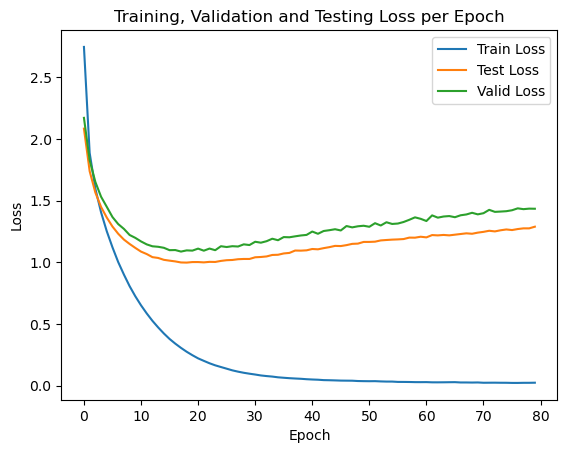

In [34]:
%matplotlib inline
showPlot(train_losses, valid_losses, test_losses)

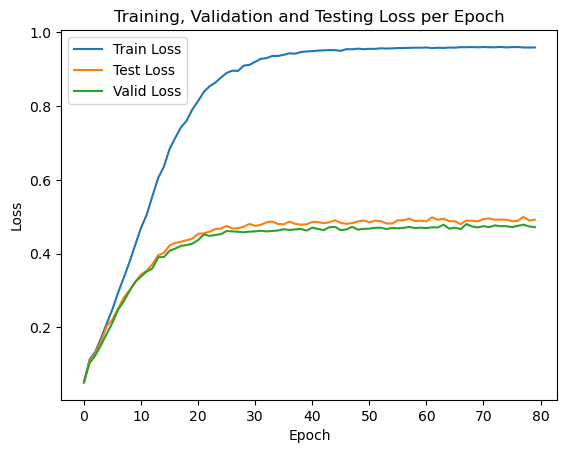

In [35]:
%matplotlib inline
showPlot(train_bleu_scores, valid_bleu_scores, test_bleu_scores)

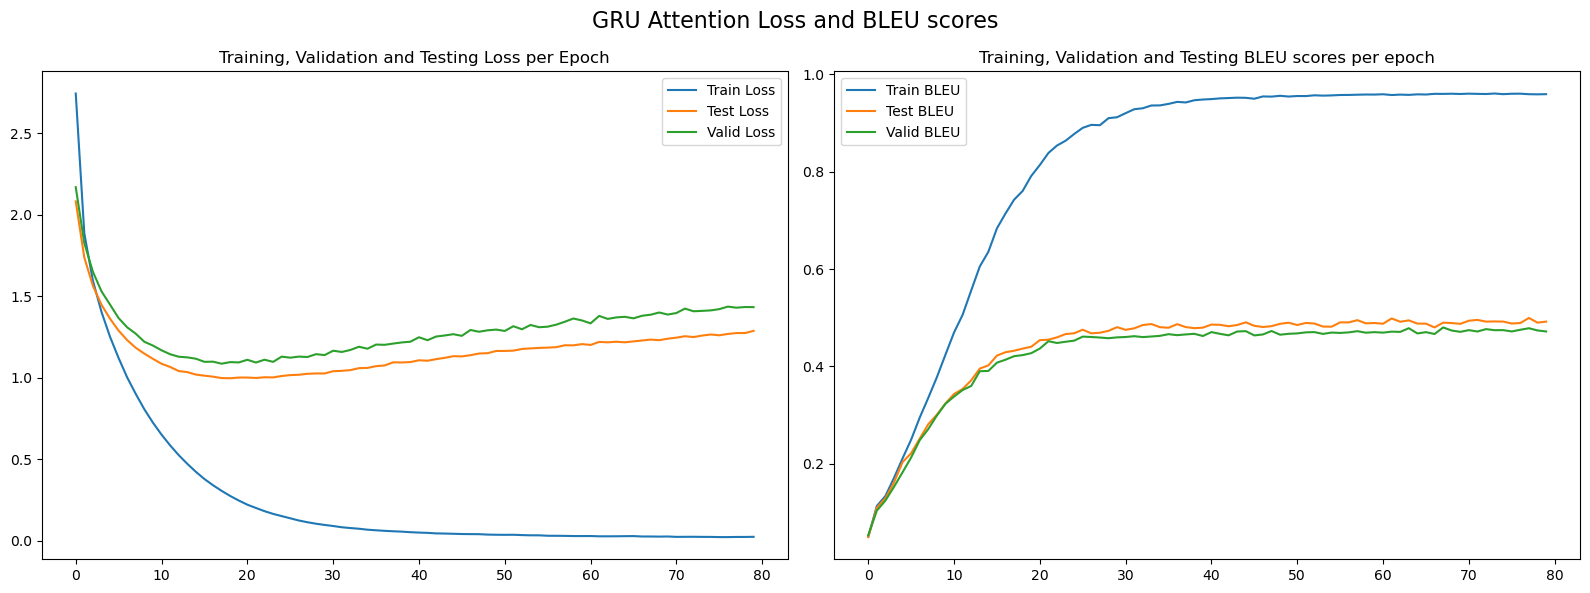

In [44]:

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Sous-graphe 1 : Losses
axs[0].plot(train_losses, label='Train Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].plot(valid_losses, label='Valid Loss')
axs[0].set_title('Training, Validation and Testing Loss per Epoch')
axs[0].legend()

# Sous-graphe 2 : BLEU scores
axs[1].plot(train_bleu_scores, label='Train BLEU')
axs[1].plot(test_bleu_scores, label='Test BLEU')
axs[1].plot(valid_bleu_scores, label='Valid BLEU')
axs[1].set_title('Training, Validation and Testing BLEU scores per epoch')
axs[1].legend()

fig.suptitle('GRU Attention Loss and BLEU scores', fontsize=16)
fig.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.savefig('GRU Attention Loss and BLEU scores.png', dpi=300)

# Ajuster les sous-graphiques
fig.tight_layout()
plt.show()
